In [1]:
#Collaborative Filtering is usually with Matrix Factorization.

#How to model Recommendation as a Neural Network?

#A neural network is for modeling complex interactions between entities.
#In our problem we have 2 entity.User and Jester.

#How can we vectorize user ?
#Ratings matrix is a good data for modeling a user by his likes.
#So we have a user vector of 100 items.

#***Here not reviewed jesters could lead some miss leading results.
#But we can also think these as Dropout. So even our model can benefit from this.
#I tried this approach also,it had good results but 
#then i decided to replace missing values with average of each user to get a embedding.
#this gave better results. But I also think this add some bias towards mean of users.
#We can exclude some items from set and try testing with some rated items excluded from training set.


#How can we model a jester?

#In fact that are latent features we don't know for Jester.
#Example Jester could be political, or about marriage,daily life...
#So we must find a way to vectorize Jester.

#Rating is 24933 user by 100 Jester matrix.
#If I transpose this then it becomes
#100 jester by 24933 user.
#This becomes an encoding for Jester based on user like.

#In fact we can use this, but dimension is so high.
#I tried 2 approaches, 
#Encode jesters by cosine, 
#Then I have a 100x100 matrix of Jester.This matrix shows how similar that one jester to others.

#Encode jesters by user , i chosed 50 dimension for PCA,Isomap
#Isomap a nonlinear dimension reduction so instead of having a jester
#mapping as 24933 dimension, we will just have 50 dimension.
#Then I have a 100x50 matrix of Jester.This matrix shows an encoding based on user like

#I trained both models, both are good, Isomapis better, since it is exactly encoding
#of what we want.

#Conclusion :
#I have a val_mean_absolute_error: 0.2 
#My values range from -1 to 1.
#so my error is 100 x 0.2 / 2 = 10
#So i can claim to guess what rating will user give to a jester with 90 accuracy.
#my guess will be around actual value by %10 ratio 



In [ ]:
#!pip install xlrd
#!pip install opt_einsum

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity 
import matplotlib.pyplot as plt
import math
import keras
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input
from keras.models import Sequential, Model
import numpy as np
from sklearn.model_selection import RepeatedKFold
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [48]:
#features = ["Office","School","Relations","Political","Sport"]
features = ["Jester1","Jester2","Jester3","Jester4","Jester5"]
john = [0.1,0.7,0.1,0.7,0.9]
jane  = [0.2,0.6,0.2,0.6,0.8]
arnold  = [0.7,0.9,0.1,0.3,0.1]
sam  = [0.6,0.7,0.1,0.5,0.1]


classes = ["john","jane","arnold","sam"]
datas = np.stack([john,jane,arnold,sam])
df_movie = pd.DataFrame(datas,columns=features,index=classes)
df_movie

,Jester1,Jester2,Jester3,Jester4,Jester5
john,0.1,0.7,0.1,0.7,0.9
jane,0.2,0.6,0.2,0.6,0.8
arnold,0.7,0.9,0.1,0.3,0.1
sam,0.6,0.7,0.1,0.5,0.1


In [49]:
df_movie.T

,john,jane,arnold,sam
Jester1,0.1,0.2,0.7,0.6
Jester2,0.7,0.6,0.9,0.7
Jester3,0.1,0.2,0.1,0.1
Jester4,0.7,0.6,0.3,0.5
Jester5,0.9,0.8,0.1,0.1


In [6]:
#read the whole data 
#so i normalize data from range [-10,10] to range [-1,1] 
def normalize_by10(x):
    return x / 10

def denormalize_by10(x):
    return x * 10

#read excel
df_orig = pd.read_excel("D:/mldata/jester/jester_dataset_1_1/jester-data-1.xls",index_col=None, header=None)

#drop 1st column which is for how many items rated by user
#replace 99 with None for easy manupulation
#normalize data by dividing to 10 so i have -1 to 1 distribution.
#data distribution seems nice,so i don't touch, i could try normalize by z value , 
df_normalized = df_orig.drop([0], 1).applymap(lambda x: None if x == 99 else x ).applymap(normalize_by10)
print("number of people:",len(df_normalized))
#display sample
df_normalized.head(5)

number of people: 24983


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-0.782,0.879,-0.966,-0.816,-0.752,-0.850,-0.985,0.417,-0.898,-0.476,...,0.282,NaN,NaN,NaN,NaN,NaN,-0.563,NaN,NaN,NaN
1,0.408,-0.029,0.636,0.437,-0.238,-0.966,-0.073,-0.534,0.888,0.922,...,0.282,-0.495,-0.029,0.786,-0.019,-0.214,0.306,0.034,-0.432,0.107
2,NaN,NaN,NaN,NaN,0.903,0.927,0.903,0.927,NaN,NaN,...,NaN,NaN,NaN,0.908,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.835,NaN,NaN,0.180,0.816,-0.282,0.621,NaN,0.184,...,NaN,NaN,NaN,0.053,NaN,NaN,NaN,NaN,NaN,NaN
4,0.850,0.461,-0.417,-0.539,0.136,0.160,0.704,0.461,-0.044,0.573,...,0.519,0.558,0.427,0.519,0.573,0.155,0.311,0.655,0.180,0.160


In [7]:
#check counts of ratings ( just round to )
unique, counts = np.unique(df_normalized.drop([0], 1).applymap(lambda x: math.floor(x)), return_counts=True)
dict(zip(unique, counts))

{-10: 74902,
 -9: 56355,
 -8: 58511,
 -7: 65006,
 -6: 53389,
 -5: 71202,
 -4: 72782,
 -3: 68934,
 -2: 77381,
 -1: 129495,
 0: 116022,
 1: 125567,
 2: 127819,
 3: 133486,
 4: 111887,
 5: 118113,
 6: 109702,
 7: 96957,
 8: 104891,
 9: 38052,
 10: 2,
 99: 687845}

In [ ]:
#check counts of ratings ( just round to )
unique, counts = np.unique(df_orig.drop([0], 1).applymap(lambda x: math.floor(x)), return_counts=True)
dict(zip(unique, counts))

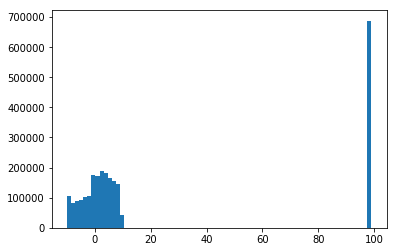

In [8]:
#lets discover distribution of data
counts, bins = np.histogram( df_orig.drop([0], 1).values, bins='auto')
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [9]:
#i will encode users by jester and jester by users
df_user_jester = df_normalized
df_jester_user = df_user_jester.T
print( "df_user_jester shape :",df_user_jester.shape )
print( "df_jester_user shape :",df_jester_user.shape )

(24983, 100)
(100, 24983)


In [34]:
#replace not commented 99(formerly replaced as NaN) with average of row
#average of row is, user's average like for jester set(of course not totally, it depends on which jester user rated )
df_jester_user_imputed =  df_jester_user.T.fillna(df_jester_user.mean(axis=1)).T
print( "df_jester_user_imputed shape :",df_jester_user_imputed.shape )
df_jester_user_imputed.head(5)

df_jester_user_imputed shape : (100, 24983)


,0,1,2,3,4,5,6,7,8,9,...,24973,24974,24975,24976,24977,24978,24979,24980,24981,24982
1,-0.782,0.408,0.090457,0.090457,0.850,-0.617,0.090457,0.684,-0.379,0.301,...,0.180000,0.090457,0.090457,0.136,0.090457,0.044,0.913,0.090457,0.090457,0.243
2,0.879,-0.029,0.020846,0.835000,0.461,-0.354,0.020846,0.316,-0.354,0.515,...,-0.942000,-0.922000,0.820000,0.175,0.020846,0.743,-0.816,0.020846,0.020846,0.267
3,-0.966,0.636,0.031657,0.031657,-0.417,0.044,0.031657,0.917,-0.942,0.515,...,-0.820000,0.031657,0.031657,0.238,0.031657,0.908,0.859,0.031657,0.031657,-0.398
4,-0.816,0.437,-0.144911,-0.144911,-0.539,-0.850,-0.144911,-0.621,-0.689,0.301,...,-0.144911,-0.144911,-0.144911,0.184,-0.144911,0.233,0.908,-0.144911,-0.144911,0.427
5,-0.752,-0.238,0.903000,0.180000,0.136,-0.709,0.859000,-0.816,-0.874,0.641,...,-0.854000,0.597000,0.879000,0.466,0.767000,0.320,0.087,-0.777000,-0.971000,-0.228


In [33]:
#for changing row missing values, i transpose ,fill with mean and then transpose again
df_user_jester_imputed =  df_user_jester.T.fillna(df_user_jester.mean(axis=1)).T
print( "df_user_jester_imputed shape :",df_user_jester_imputed.shape )
df_user_jester_imputed.head(5)

df_user_jester_imputed shape : (24983, 100)


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-0.782000,0.879000,-0.966000,-0.816000,-0.752,-0.850,-0.985,0.417,-0.898000,-0.476000,...,0.282000,-0.343189,-0.343189,-0.343189,-0.343189,-0.343189,-0.563000,-0.343189,-0.343189,-0.343189
1,0.408000,-0.029000,0.636000,0.437000,-0.238,-0.966,-0.073,-0.534,0.888000,0.922000,...,0.282000,-0.495000,-0.029000,0.786000,-0.019000,-0.214000,0.306000,0.034000,-0.432000,0.107000
2,0.709939,0.709939,0.709939,0.709939,0.903,0.927,0.903,0.927,0.709939,0.709939,...,0.709939,0.709939,0.709939,0.908000,0.709939,0.709939,0.709939,0.709939,0.709939,0.709939
3,0.265812,0.835000,0.265812,0.265812,0.180,0.816,-0.282,0.621,0.265812,0.184000,...,0.265812,0.265812,0.265812,0.053000,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812
4,0.850000,0.461000,-0.417000,-0.539000,0.136,0.160,0.704,0.461,-0.044000,0.573000,...,0.519000,0.558000,0.427000,0.519000,0.573000,0.155000,0.311000,0.655000,0.180000,0.160000


In [32]:
#create a cosine embedding for jesters
#this embedding is how similar each jester to other jesters
print("df_jester_user_imputed shape",df_jester_user_imputed.shape)
cosine_similarities = cosine_similarity(df_jester_user_imputed, df_jester_user_imputed) 
cosine_similarities.shape

df_jester_user_imputed shape (100, 24983)


(100, 100)

In [81]:
#this is a similarity matrix, check diagonals are 1
#everything is totally similar to itself.
pd.DataFrame(cosine_similarities).head(100)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.363639,0.362482,0.192402,0.154229,0.241124,0.141009,0.122613,0.280543,0.343866,...,0.211532,0.166561,0.239209,0.219170,0.202124,0.217806,0.218745,0.165215,0.120304,0.211604
1,0.363639,1.000000,0.281671,0.268723,0.178298,0.211195,0.166878,0.098297,0.225424,0.257425,...,0.112402,0.108836,0.120372,0.107698,0.109151,0.114361,0.126659,0.197690,0.104505,0.209245
2,0.362482,0.281671,1.000000,0.317075,0.181618,0.253264,0.140682,0.138792,0.293858,0.286815,...,0.143237,0.141169,0.156439,0.145266,0.166194,0.141315,0.142453,0.167087,0.143311,0.241857
3,0.192402,0.268723,0.317075,1.000000,0.130072,0.140820,0.175679,0.111144,0.380116,0.119030,...,-0.062334,0.059819,-0.081025,0.031028,0.065239,0.012634,-0.010448,0.171852,0.218569,0.139905
4,0.154229,0.178298,0.181618,0.130072,1.000000,0.187275,0.193046,0.150185,0.080237,0.162414,...,0.109825,0.094893,0.117665,0.094127,0.100794,0.094611,0.096928,0.151462,0.094884,0.186813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.217806,0.114361,0.141315,0.012634,0.094611,0.325146,0.043766,-0.009105,0.161700,0.230662,...,0.473786,0.456266,0.524742,0.479251,0.472858,1.000000,0.535115,0.289366,0.325406,0.349832
96,0.218745,0.126659,0.142453,-0.010448,0.096928,0.297368,0.064704,0.012801,0.120687,0.220881,...,0.467301,0.393863,0.519620,0.446566,0.406739,0.535115,1.000000,0.298900,0.306144,0.321826
97,0.165215,0.197690,0.167087,0.171852,0.151462,0.231539,0.080746,-0.030296,0.083530,0.136954,...,0.276301,0.285830,0.325251,0.220889,0.245931,0.289366,0.298900,1.000000,0.275670,0.450933
98,0.120304,0.104505,0.143311,0.218569,0.094884,0.179186,0.090675,0.065264,0.219272,0.118074,...,0.226313,0.289554,0.219427,0.302806,0.304224,0.325406,0.306144,0.275670,1.000000,0.263642


In [14]:
#our data is 25K rows x 100 colums
#for neural network i will use a 
#jester embeding + user embeding -> rating
#so i create a row for every cell
#this method return 25K x 100 = 2500K rows = 
def get_as_train_data(df_tabular,jester_encoding):    
    num_rows = len(df_tabular)    
    df_user_jester_values = df_tabular.values
    user_joke_rating = []
    y_rating = []
    for index_user in range(num_rows):    
        for joke_index,rating  in enumerate(df_tabular.iloc[index_user].values):        
            #if cell defined use it if not skip
            if not pd.isna( rating ):
                    
                jester_embedded = jester_encoding[joke_index]
                user_embedded  = df_user_jester_values[index_user:index_user+1,:].flatten()            
                                        
                embed_concat = np.hstack( (jester_embedded,user_embedded)).flatten()            
                y_rating.append(rating)                
                user_joke_rating.append(embed_concat)
                    
    return np.array(user_joke_rating),np.array(y_rating)

In [15]:
#get a training set for cosine trial
x_train,y_train = get_as_train_data(df_user_jester_imputed,cosine_similarities)
print("x_train",x_train.shape)
print("y_train",y_train.shape)

x_train (2498300, 200)
y_train (2498300,)


In [52]:
y_train[0:10]

array([-0.782,  0.879, -0.816, -0.752, -0.85 , -0.985,  0.417, -0.898,
       -0.476, -0.85 ])

In [16]:
from keras.optimizers import SGD
#I tried with different optimizations,different learning rates.
#below configurations seems good enough, it could try schedulers also
def mlp_model_cosine():
	# create model
	model = Sequential()
	model.add(Dense(120, input_dim=200, kernel_initializer='normal', activation='relu'))
	model.add(Dense(60, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_error'])
    
	return model

def mlp_model_iso_deep():
	# create model
	model = Sequential()
	model.add(Dense(160, input_dim=150, kernel_initializer='normal', activation='relu'))
	model.add(Dropout(0.2))
	model.add(Dense(80, kernel_initializer='normal', activation='relu'))
	model.add(Dropout(0.2))
	model.add(Dense(40, kernel_initializer='normal', activation='relu'))
	model.add(Dropout(0.2))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	opt = keras.optimizers.Adam(lr=0.0001)
	model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=['mean_absolute_error'])
    
	return model

In [45]:
y_train[0]

-0.782

In [51]:
#define cosine model and train,
# here we have train data as (2498300, 200) 
# 100 column jester embedding + 100 column user embedding
#use early stopping
model_cosine = mlp_model_cosine()

model_cosine.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 120)               24120     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                7260      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
Total params: 31,441
Trainable params: 31,441
Non-trainable params: 0
_________________________________________________________________


In [17]:


print("trainx",x_train.shape)
print("trainy",y_train.shape)
print(model_cosine.summary())
#if no improvement in 5 epoch more than 0.01 then quit training
#we could also use Model checkpoint to save best model
es = EarlyStopping(monitor='val_mean_absolute_error', mode='min', min_delta=0.01,patience=5)
history = model_cosine.fit(x_train,y_train,batch_size = 256,
                           shuffle=True,validation_split = 0.125,epochs = 50,verbose = 1,callbacks=[es])

trainx (2498300, 200)
trainy (2498300,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 120)               24120     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                7260      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
Total params: 31,441
Trainable params: 31,441
Non-trainable params: 0
_________________________________________________________________
None
Train on 2186012 samples, validate on 312288 samples
Epoch 1/50
2186012/2186012 [==============================] - 22s 10us/step - loss: 0.1355 - mean_absolute_error: 0.2686 - val_loss: 0.1378 - val_mean_absolute_error: 0.2682
Epoch 2/50
2186012/2186012 [==============================] - 24s 11us/step - loss: 0.1274 - mean_absolute_e

2186012/2186012 [==============================] - 24s 11us/step - loss: 0.0299 - mean_absolute_error: 0.1199 - val_loss: 0.0368 - val_mean_absolute_error: 0.1385
Epoch 44/50
2186012/2186012 [==============================] - 24s 11us/step - loss: 0.0288 - mean_absolute_error: 0.1177 - val_loss: 0.0314 - val_mean_absolute_error: 0.1226


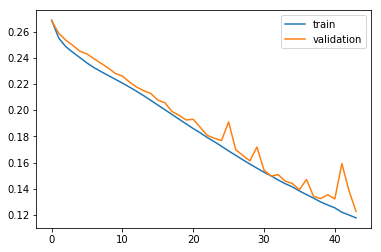

In [18]:
from matplotlib import pyplot

pyplot.plot(history.history['mean_absolute_error'], label='train')
pyplot.plot(history.history['val_mean_absolute_error'], label='validation')
pyplot.legend()
pyplot.show()
#seems validation begin fluctuating after 20-25 epoch,
#since this model is simple and no regularization(like dropout) it begins overfitting

In [61]:
#this method is for preparing suggestiong by user
#model_trained : model trained
#user_index : which user we want to suggest for
#user_embeddings : source of user_embedding, we have only 1 type of embedding
#jester_embeddings : source of jester embedding, could be cosine or isomap
#
#return
#predictions : what will model predict for this user (for all 100 jester)
#df_all : just a  dataframe for checking results for all 100 jester
#df_suggestions : a  dataframe for checking results for only not rated items
#mean_abs_error : what will our model's absolute error be for this user
def get_user_preds(model_trained,user_index,user_embeddings,jester_embeddings,is_return_suggestions):
    #get user row values
    user_row =  user_embeddings.iloc[user_index].values
    #i want to also know Nan values
    normalized_row = df_normalized.iloc[user_index].values
    #create jester + user embeddings for predictions for all combinations    
    all_predict_input = []
    for i in range(len(jester_embeddings)):
        jester_embedded = jester_embeddings[i]
        embed_concat = np.hstack( (jester_embedded,user_row)).flatten()
        all_predict_input.append( embed_concat )
    #predict all movies for user(even ones which were rated before)    
    predictions = model_trained.predict(np.array(all_predict_input))
    
    actual_prediction = []
    abs_error = 0
    num_notnulls = 0
    status = []
    for i in range(len(jester_embedded)):
        #df_normalized has data with nan ,only add rated items to absolute error
        if not pd.isna(  normalized_row[i] ):
            status.append("Existing")
            num_notnulls += 1
            abs_error += abs(user_row[i] - predictions[i][0])
        else:
            status.append("New")
                                            
        actual_prediction.append([round(user_row[i],3) ,round(predictions[i][0],3) ])
    #mean absolute error for user
    mean_abs_error= abs_error / num_notnulls
    
    #I want to create a dataframe for predictions
    #Actual : Value in original file
    #Prediction : What will this network guess for this row
    #stat : status of cell, New means it is guessed rating, Existing means already rated
    df_all=pd.DataFrame(actual_prediction,columns=["actual","prediction"])
    #before we divide values by 10 ,now multiple 10 
    df_all = df_all.applymap(denormalize_by10)        
    df_all["status"] = status
    #also return suggestions as a 2nd dataframe
    df_suggestions = df_all[df_all["status"]=="New"]
    #sort suggestions
    df_suggestions = df_suggestions.sort_values('prediction',ascending=False)
    return predictions ,df_all ,df_suggestions,mean_abs_error
    



In [62]:
predictions  ,df_all  ,df_suggestions,mean_abs_error= get_user_preds(model_cosine, 19,df_user_jester_imputed,cosine_similarities,True)
#check suggestions for user
#here actual is average of user infact it is Nan
print("df_suggestions len",len(df_suggestions))
df_suggestions

df_suggestions len 47


,actual,prediction,status
77,-0.16,1.76,New
94,-0.16,1.33,New
95,-0.16,1.28,New
99,-0.16,1.13,New
86,-0.16,0.76,New
2,-0.16,0.53,New
50,-0.16,0.43,New
87,-0.16,0.39,New
57,-0.16,0.31,New
96,-0.16,0.26,New


In [64]:
#check all values for user
print("mean_abs_error for this user",round(mean_abs_error,2))
print(len(df_all))
print("existing predictions :",len(df_all[df_all["status"] == "Existing"]))
df_all[df_all["status"] == "Existing"]
#explanation of data for 1st row

#actual prediction stat
#3.01 4.09 Existing

#originally user rated 3.01
#if we had guessed the rating with our model we will guess as 4.09
#difference is nearly 1
#our values are between -10 and 10 
#so 1 error in 20 
# %5 error 

mean_abs_error for this user 0.13
100
existing predictions : 53


,actual,prediction,status
1,7.62,6.04,Existing
4,-8.64,-8.68,Existing
5,2.43,0.45,Existing
6,8.93,7.61,Existing
7,-6.60,-6.29,Existing
9,-9.47,-9.27,Existing
10,-2.77,-2.74,Existing
11,-0.73,0.50,Existing
12,-9.27,-9.31,Existing
14,-1.02,-1.03,Existing


50

In [41]:
print("df_jester_user_imputed shape:",df_jester_user_imputed.shape)

df_jester_user_imputed shape: (100, 24983)


In [82]:
#create a isomap dimension reduction,and use it for embedding
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

#Uncomment PCA to try with PCA
embedding = Isomap(n_components=50)
#embedding = PCA(n_components=50)
isomap_jester_user = embedding.fit_transform(df_jester_user_imputed)
isomap_jester_user.shape


(100, 50)

In [83]:
#lets check how it seems
#if u want to see in better format open comment below
#pd.DataFrame(isomap_jester_user).head(10)
#how a row of encoding seems
isomap_jester_user[0:1]

array([[  6.14369566, -53.4447873 ,  71.76056713, -16.45979903,
         -9.95014713,  52.14496558,  56.57160855, -26.21157677,
         11.2128202 , -11.29871776,  -6.44646712, -15.15314767,
        -24.00819616,   7.1082318 , -29.42260822, -32.75670129,
        -25.79705065, -29.75658148,   3.22306676,  11.29462771,
         -4.97200716, -12.96189093,  10.19375667,  -3.59249533,
         14.59007113, -24.91498061,  24.1835739 ,  18.15537926,
         -4.53117301,  -9.36361389,   0.34956097,  -6.82847442,
         17.4476063 ,  20.03144346,  -5.73676193, -14.00569047,
         -0.38443106,   5.54708552,  -8.5311655 ,   7.70771376,
        -16.29256152,  10.04040147,  -6.72577691,   0.65183937,
         -3.59887713,  -4.08181378,  -3.78276877,   0.56247239,
          3.76266875,   0.85011642]])

In [84]:
#values are not scaled, lets normalize them, so data becomes better distributed
normalized_isomap_jester_user = isomap_jester_user / np.sqrt(np.sum(isomap_jester_user**2))
pd.DataFrame(normalized_isomap_jester_user).head(10)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.003598,-0.031299,0.042025,-0.009639,-0.005827,0.030537,0.033130,-0.015350,0.006567,-0.006617,...,-0.009541,0.005880,-0.003939,0.000382,-0.002108,-0.002390,-0.002215,0.000329,0.002204,0.000498
1,0.013318,0.031538,0.061208,0.047045,0.000832,0.038146,0.055198,0.012870,-0.013728,-0.016937,...,-0.002434,-0.000904,0.001516,-0.001411,-0.000201,0.001552,0.001985,0.001145,-0.001686,-0.001314
2,0.034264,0.004857,0.029562,0.021828,0.034461,0.041423,-0.022792,-0.021133,0.042684,0.008258,...,0.002676,0.004587,-0.001496,0.002136,-0.002349,0.005103,0.000431,-0.002408,0.000762,-0.001955
3,0.082741,0.013235,-0.022482,0.009294,0.008043,0.013322,-0.028907,-0.030347,0.007491,-0.003608,...,0.000034,0.001885,0.000874,0.005193,0.004051,0.002528,-0.002681,-0.000200,0.002835,0.000041
4,0.023486,0.016514,-0.015396,0.060635,-0.001698,0.022671,-0.022397,0.038251,0.007865,-0.019012,...,-0.004757,-0.004979,-0.002782,0.000146,-0.005726,-0.007892,-0.003019,-0.001621,-0.000625,0.002359
5,-0.039439,-0.000256,-0.026738,0.023171,-0.000620,-0.019466,-0.009239,0.006821,0.004153,-0.033870,...,-0.000751,-0.005325,-0.004297,0.005027,-0.007593,0.000213,0.000886,-0.000128,-0.003073,0.000143
6,0.049959,-0.016227,-0.002842,0.045663,-0.012821,-0.001726,0.008146,-0.024678,-0.017210,0.042930,...,0.000974,-0.000675,-0.006745,-0.002923,0.005839,-0.000342,-0.000494,0.002035,0.002682,0.000033
7,0.056970,-0.043046,0.006895,0.007771,0.015078,-0.011905,0.023666,-0.012072,-0.001327,0.011769,...,0.005525,0.002174,0.000494,0.001839,-0.007990,-0.004937,0.000721,0.004870,0.000565,0.001713
8,0.084335,-0.004663,0.036704,-0.044544,0.009813,0.012348,-0.010944,0.021749,-0.007807,-0.004444,...,0.008272,0.003088,-0.008509,0.001924,-0.006199,0.002876,0.004734,-0.000151,0.002749,0.001214
9,0.001511,-0.059048,0.031583,-0.013235,-0.014597,0.003822,0.004080,-0.004241,0.023993,0.026323,...,0.003597,-0.010668,-0.005474,0.005340,0.000569,0.006516,-0.001149,-0.006269,-0.004447,-0.002110


In [85]:
print("df_user_jester_imputed shape:",df_user_jester_imputed.shape)
print("normalized_isomap_jester_user shape:",normalized_isomap_jester_user.shape)

df_user_jester_imputed shape: (24983, 100)
normalized_isomap_jester_user shape: (100, 50)


In [86]:
#get a new projected data set
#here embedding length is 150
#50 jester columns + 100 user columns
x_train_iso,y_train_iso = get_as_train_data(df_user_jester_imputed,normalized_isomap_jester_user)
print("x_train_iso",x_train_iso.shape)
print("y_train_iso",y_train_iso.shape)

x_train_iso (2498300, 150)
y_train_iso (2498300,)


In [87]:
#get isomap model
model_isomap_deep = mlp_model_iso_deep()
print(model_isomap_deep.summary())

#if no improvement of 0.01 on mean absolute error, for 5 epochs dont train anymore
es = EarlyStopping(monitor='val_mean_absolute_error', mode='min', min_delta=0.01,patience=5)

history_iso = model_isomap_deep.fit(x_train_iso,y_train_iso,
                                    batch_size = 256,shuffle=True,
                                    validation_split = 0.125,
                                    epochs = 50,
                                    verbose = 1,
                                    callbacks=[es])

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 160)               24160     
_________________________________________________________________
dropout_55 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 80)                12880     
_________________________________________________________________
dropout_56 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 40)                3240      
_________________________________________________________________
dropout_57 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 1)               

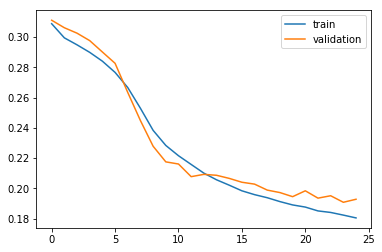

In [88]:
from matplotlib import pyplot
pyplot.plot(history_iso.history['mean_absolute_error'], label='train')
pyplot.plot(history_iso.history['val_mean_absolute_error'], label='validation')
pyplot.legend()
pyplot.show()


In [89]:
#predict for isomap model
predictions  ,df_all  ,df_suggestions,mean_abs_error= get_user_preds(model_isomap_deep, 19,df_user_jester_imputed,normalized_isomap_jester_user,True)
print("mean_abs_error for this user",round(mean_abs_error,2))
df_all[df_all["status"] == "Existing"]


mean_abs_error for this user 0.34


,actual,prediction,status
1,7.62,5.97,Existing
4,-8.64,-1.53,Existing
5,2.43,1.70,Existing
6,8.93,7.12,Existing
7,-6.60,0.03,Existing
9,-9.47,-1.02,Existing
10,-2.77,0.06,Existing
11,-0.73,-1.08,Existing
12,-9.27,-0.90,Existing
14,-1.02,-1.76,Existing


In [ ]:
y_train_iso[0]

-0.782

In [ ]:
print("x_train_iso shape:",x_train_iso.shape)

x_train_iso shape: (2498300, 150)


In [ ]:
#as a last step make a kfold verification for our neural network
#the results could not gurantee success on unseen data
split_size = 8
slicer = RepeatedKFold(n_splits=split_size, n_repeats=1, random_state=128452)
all_scores = []
for train_index, test_index in slicer.split(x_train_iso):
	X_train, X_test = x_train_iso[train_index], x_train_iso[test_index]
	y_train, y_test = y_train_iso[train_index], y_train_iso[test_index]

	model_isomap_deep = mlp_model_iso_deep()
	model_isomap_deep.fit(X_train,y_train,shuffle=True,
                                    batch_size = 256,                                    
                                    epochs = 10,
                                    verbose = 2)
	scores = model_isomap_deep.evaluate(X_test, y_test, verbose=0)
	all_scores.append(scores[1])
	print("for this fold absolute error",scores[1])

Epoch 1/10
 - 54s - loss: 0.0277 - mean_absolute_error: 0.3102
Epoch 2/10
 - 55s - loss: 0.0254 - mean_absolute_error: 0.3008
Epoch 3/10
 - 44s - loss: 0.0245 - mean_absolute_error: 0.2963
Epoch 4/10
 - 47s - loss: 0.0234 - mean_absolute_error: 0.2916
Epoch 5/10
 - 52s - loss: 0.0222 - mean_absolute_error: 0.2860
Epoch 6/10
 - 57s - loss: 0.0205 - mean_absolute_error: 0.2788
Epoch 7/10
 - 55s - loss: 0.0181 - mean_absolute_error: 0.2682
Epoch 8/10
 - 55s - loss: 0.0153 - mean_absolute_error: 0.2540
Epoch 9/10
 - 52s - loss: 0.0129 - mean_absolute_error: 0.2403
Epoch 10/10
 - 54s - loss: 0.0113 - mean_absolute_error: 0.2304
for this fold absolute error 0.2121906280517578
Epoch 1/10
 - 42s - loss: 0.0277 - mean_absolute_error: 0.3101
Epoch 2/10
 - 41s - loss: 0.0255 - mean_absolute_error: 0.3012
Epoch 3/10
 - 40s - loss: 0.0246 - mean_absolute_error: 0.2966
Epoch 4/10
 - 40s - loss: 0.0235 - mean_absolute_error: 0.2920
Epoch 5/10
 - 43s - loss: 0.0223 - mean_absolute_error: 0.2865
Epoch 

In [ ]:
all_scores

In [ ]:
#kfold result
#so kfold absolute error is also 0.2
#since range is -1 to 1, it make %90 accuracy
sum(all_scores) / len(all_scores)